In [1]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
import statsmodels.api as sm 
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.stats import spearmanr
from scipy.interpolate import interp1d
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [5]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [6]:
def n_derivative(arr, degree=1):
    """Compute the n-th derivative."""
    result = arr.copy()
    for i in range(degree):
        result = np.gradient(result)
    return result


def close_zero(arr, threshold=1e-4):
    return (abs(arr) < threshold)

def maxima_2(arr):
    
    
    bl = close_zero(n_derivative(arr, 2))
    b2 = close_zero(n_derivative(arr, 3))
    try_it = bl & b2 & (n_derivative(arr, 3) > 0)

    for i, e in reversed(list(enumerate(try_it))):

        if e == False:
            k = i
            break         
            
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-4)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-5)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break
                
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-6)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break 
                
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-7)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break  
                
    return k


In [7]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [8]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [9]:
nii_bo_dir = '../../data/niis'

In [10]:
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)

In [11]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [12]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [13]:
network_dir = '../../data/yeo_networks'

In [14]:
ddir = '../../data/'

In [15]:
results_dir = os.path.join(ddir, 'results')
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [16]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [17]:
template = se.helpers._gray(res=2)

In [18]:
network_list = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention',
                'Limbic ', 'Frontoparietal', 'Default']


In [19]:
factors=700

In [20]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [21]:
pieman_data = loadmat(pieman_name)

In [22]:
debug = False

In [23]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [24]:
data = np.array(data)
conds = np.array(conds)

In [25]:
n_nets = 7

In [26]:
yeo_colors = pd.read_fwf(os.path.join(network_dir, 'Yeo2011_' + str(n_nets) + 'Networks_ColorLUT.txt'))
yeo_colors.columns = ["inds", "networks", "x", "y", "z", "labels"]


In [27]:
if n_nets == 17:
    yeo_color_labels = ['visual peripheral', 'visual central', 'somatomotor A', 'somatomotor B', 'dorsal attention A', 
                        'dorsal attention B', 'ventral attention', 'salience', 'limbic A', 'limbic B', 'control C', 
                        'control A', 'control B', 'default D (auditory)', 'default C', 'default A', 'default B']
elif n_nets == 7:
    yeo_color_labels = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ',
                        'Frontoparietal', 'Default']
    
yeo_colors['labels'] = yeo_color_labels

In [28]:

color_stacked = np.array([])
for i in np.arange(0,n_nets+1):
    if color_stacked.shape[0]==0:
        color_stacked = yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values
    else:
        color_stacked = np.vstack((color_stacked, yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values))
color_stacked = color_stacked/255

## pieman pca decoding

In [29]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Visual.csv']


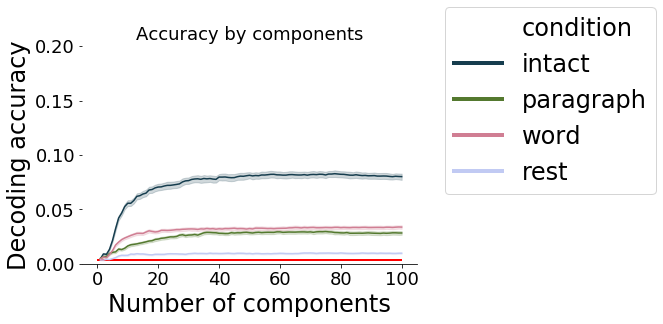

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Somatomotor.csv']


<Figure size 432x288 with 0 Axes>

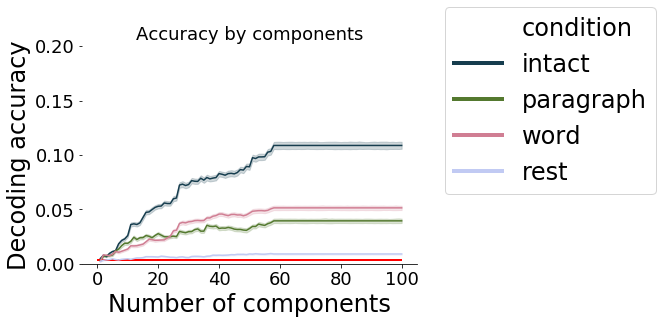

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Dorsal Attention.csv']


<Figure size 432x288 with 0 Axes>

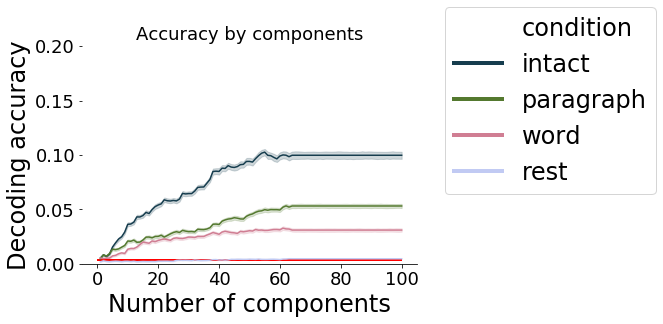

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Ventral Attention.csv']


<Figure size 432x288 with 0 Axes>

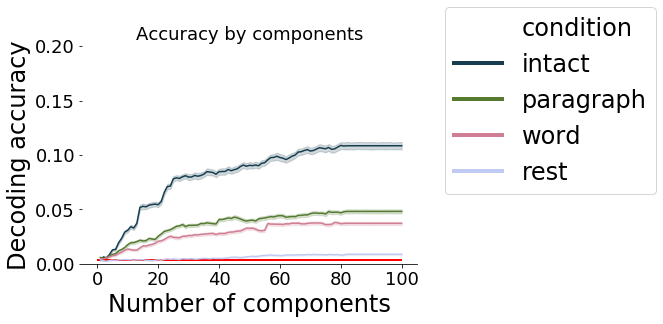

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Limbic .csv']


<Figure size 432x288 with 0 Axes>

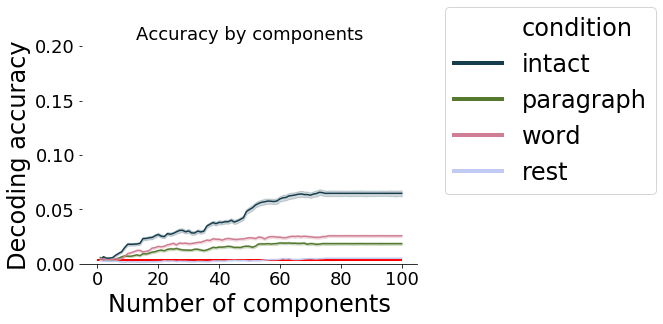

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Frontoparietal.csv']


<Figure size 432x288 with 0 Axes>

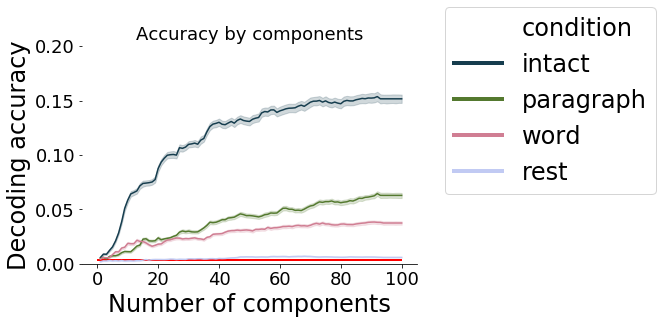

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Default.csv']


<Figure size 432x288 with 0 Axes>

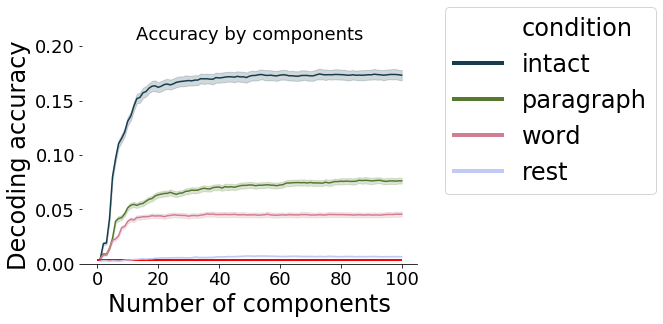

<Figure size 432x288 with 0 Axes>

In [30]:
for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    print(conds)
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
    
    outfile = os.path.join(figdir, 'Accuracy_by_components_' + network_list[n] + '.pdf')
    
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    ax.set_title('Accuracy by components')
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .2)
    ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
    #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    #fig.savefig(outfile, bbox_inches='tight')
    plt.show()
    plt.clf()

In [31]:
# for n in np.arange(len(network_list)):

#     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
#     full_data = pd.DataFrame()
#     for c in conds:
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)


#     ydata = full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
#     xdata = np.array(full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

#     popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)
    
#     hill_all[n, 0] = popt[1]
    
#     max_i = ydata.max()
    
#     maxs_all[n, 0] = max_i

#     max_loc = np.where(ydata==max_i)[0][0]

#     max_p = full_data[full_data['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
#     max_w = full_data[full_data['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
#     max_r = full_data[full_data['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


#     spearmans_all[n, 0] = spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0]


In [32]:
# for n in np.arange(len(network_list)):

#     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
#     full_data = pd.DataFrame()
#     for c in conds:
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)

            
#     conditions = ['intact', 'paragraph', 'word', 'rest']


#     for e, c in enumerate(conditions):


#         ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
#         xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

#         popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        
#         i = 0
        
#         hill_all[e, n, i] = popt[1]

#         maxs_all[e, n, i] = ydata.max()


In [33]:
# outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

In [34]:
# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y="accuracy",
#              hue="condition",
#              data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
# sns.despine(ax=ax, left=True)
# ax.set_title('Accuracy by components')
# ax.set_ylabel('Decoding accuracy',fontsize=24)
# ax.set_xlabel('Number of components',fontsize=24)
# ax.set_ylim(0, .25)
# ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
# #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
# l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
# for line in l.get_lines():
#     line.set_linewidth(4.0)
# fig.savefig(outfile, bbox_inches='tight')

In [35]:
# full_data['diff'] = full_data.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(2)/2

In [36]:
# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y='diff',
#              hue="condition",
#              data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])

In [37]:

# lm = sns.lmplot(x="dims", y="diff",
#              hue="condition",
#              data=full_data, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
# axes = lm.axes
# axes[0,0].set_ylim(0,.02)
# axes[0,0].set_xlim(1,100)


In [39]:

# for n in np.arange(len(network_list)):
#     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
#     full_data = pd.DataFrame()
#     for c in conds:
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)
            
#     for i in range(3):
#         full_data_temp = full_data[full_data['third']==i]

#         ydata = full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
#         xdata = np.array(full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

#         popt, pcov = curve_fit(func, xdata, ydata, maxfev=8000)
        
#         hill_all[n, i+1] = popt[1]

#         max_i = ydata.max()

#         maxs_all[n, i+1] = max_i

#         max_loc = np.where(ydata==max_i)[0][0]

#         max_p = full_data_temp[full_data_temp['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
#         max_w = full_data_temp[full_data_temp['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
#         max_r = full_data_temp[full_data_temp['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


#         spearmans_all[n, i+1] = spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0]


In [40]:
# for n in np.arange(len(network_list)):
    

#     resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

#     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
#     full_data = pd.DataFrame()
#     for c in conds:
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)

            
#     conditions = ['intact', 'paragraph', 'word', 'rest']

#     hill_all = np.zeros((4, 4))
#     maxs_all = np.zeros((4, 4))


#     for e, c in enumerate(conditions):


#         ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
#         xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

#         popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

#         f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
#         y = f(xdata)

#         hill_all[e, 0] = xdata[maxima_2(y)].min()

#         maxs_all[e, 0] = func(xdata[maxima_2(y)].min(), *popt)

In [41]:
# def n_derivative(arr, degree=1):
#     """Compute the n-th derivative."""
#     result = arr.copy()
#     for i in range(degree):
#         result = np.gradient(result)
#     return result


# def close_zero(arr, threshold=1e-4):
#     return (abs(arr) < threshold)

# def maxima_2(arr):
    
    
#     bl = close_zero(n_derivative(arr, 2))
#     b2 = close_zero(n_derivative(arr, 3))
#     #bl[0:3]=False
#     #bl[90:]=False
#     #btry = close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)))
    
#     #try_it = bl & (n_derivative(arr, 3) > 0)
#     #try_it = ~close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)))& (n_derivative(arr, 3) > 1e-8)
#     #try_it = btry & (n_derivative(arr, 3) > 1e-10)
#     try_it = bl & b2 & (n_derivative(arr, 3) > 0)
#     if not np.any(try_it):
#         try_it[0]=True
    
#     return try_it


In [42]:
# maxs_ns = np.zeros((7, 4, 4))
# hills_ns = np.zeros((7, 4, 4))

# hill_all = np.zeros((4, 4))
# maxs_all = np.zeros((4, 4))

# #for n in np.arange(len(network_list)):
# for n in [6]:   

#     resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

#     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
#     full_data = pd.DataFrame()
#     for c in conds:
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)

            
#     conditions = ['intact', 'paragraph', 'word', 'rest']

#     hill_all = np.zeros((4, 4))
#     maxs_all = np.zeros((4, 4))


#     for e, c in enumerate(conditions):


#         ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
#         xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

#         popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

#         f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
#         y = f(xdata)

#         hill_all[e, 0] = maxima_2(y)

#         maxs_all[e, 0] = func(maxima_2(y), *popt)
        

#         plt.plot(xdata, ydata)
#         plt.plot(xdata, func(xdata, *popt), 'r-')
#         plt.axvline(x=maxima_2(y), color='g', linestyle='-')
#         #plt.axvline(x=xdata[maxima_2(y)].min(), color='g', linestyle='-')
#         #plt.axvline(x=popt[2], color='black', linestyle='-')
#         plt.show()
#         plt.plot(n_derivative(y, 2))
#         plt.plot(n_derivative(y, 3))
#         plt.axvline(x=maxima_2(y), color='g', linestyle='-')

        
#         plt.show()

In [43]:

# maxs_ns = np.zeros((7, 4, 4))
# hills_ns = np.zeros((7, 4, 4))

# hill_all = np.zeros((4, 4))
# maxs_all = np.zeros((4, 4))

# #for n in np.arange(len(network_list)):
# for n in [4]:   

# #     resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

# #     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
# #     full_data = pd.DataFrame()
# #     for c in conds:
# #         data = pd.read_csv(c)
# #         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

# #         if full_data.empty:
# #             full_data = data
# #         else:
# #             full_data = full_data.append(data)

            
# #     conditions = ['intact', 'paragraph', 'word', 'rest']

# #     hill_all = np.zeros((4, 4))
# #     maxs_all = np.zeros((4, 4))


# #     for e, c in enumerate(conditions):


# #         ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
# #         xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

# #         popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

# #         f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
# #         y = f(xdata)

# #         hill_all[e, 0] = xdata[maxima_2(y)].min()

# #         maxs_all[e, 0] = func(xdata[maxima_2(y)].min(), *popt)
        
# #         plt.plot(xdata, ydata)
# #         plt.plot(xdata, func(xdata, *popt), 'r-')
# #         plt.axvline(x=xdata[~maxima_2(y)].max(), color='g', linestyle='-')
# #         plt.show()
        
# #         plt.plot(n_derivative(y, 2))
# #         plt.plot(n_derivative(y, 3))
# #         plt.axvline(x=xdata[~maxima_2(y)].max(), color='g', linestyle='-')
# #         plt.show()
        
#     resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'
    
#     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
#     full_data = pd.DataFrame()
#     for c in conds:
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)

#     #conditions = ['intact', 'paragraph', 'word', 'rest']
#     conditions = ['intact']
    
#     for i in np.arange(1, 4):
#     #for i in [1]:
#         full_data_temp = full_data[full_data['third']==i-1]

#         for e, c in enumerate(conditions):


#             ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
#             xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

#             popt, pcov = curve_fit(func, xdata, ydata, maxfev=1000000)
    
#             f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
#             y = f(xdata)

#             hill_all[e, i] = maxima_2(y)

#             maxs_all[e, i] = func(maxima_2(y), *popt)

#             plt.plot(xdata, ydata)
#             plt.plot(xdata, func(xdata, *popt), 'r-')
#             plt.axvline(x=maxima_2(y), color='g', linestyle='-')
#             plt.show()
#             plt.plot(n_derivative(y, 2))
#             plt.plot(n_derivative(y, 3))
#             #plt.axvline(x=xdata[~maxima_2(y)].max(), color='g', linestyle='-')
#             plt.axvline(x=maxima_2(y), color='g', linestyle='-')
#             plt.show()
            
#     hills_ns[n, :, :] = hill_all
    
#     maxs_ns[n, :, :] = maxs_all

In [45]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Visual.csv']
Visual
1


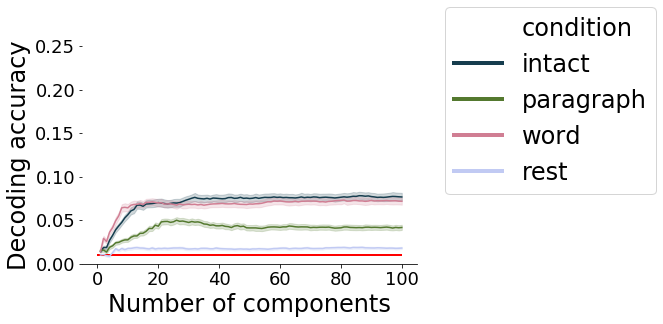

Visual
2


<Figure size 432x288 with 0 Axes>

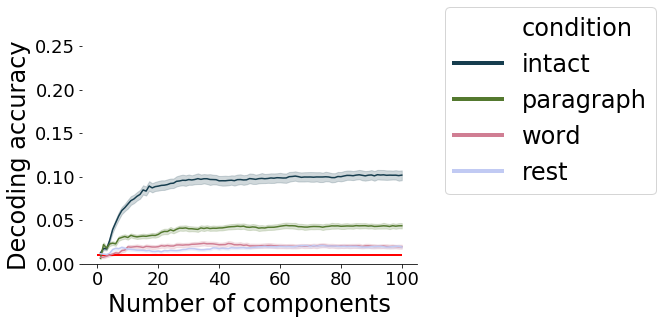

Visual
3


<Figure size 432x288 with 0 Axes>

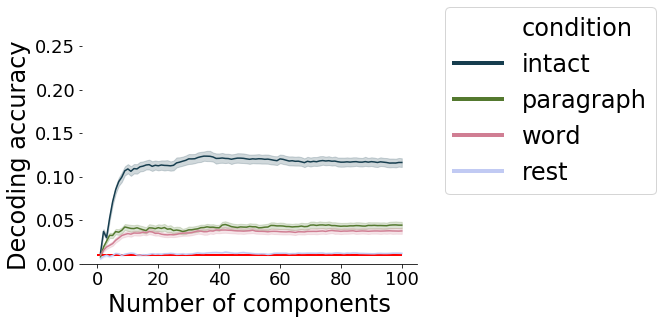

<Figure size 432x288 with 0 Axes>

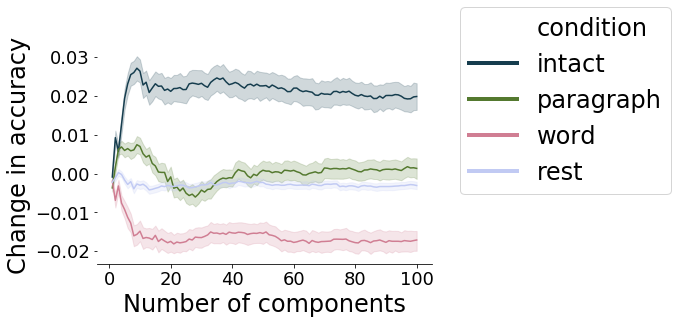

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Somatomotor.csv']
Somatomotor
1


<Figure size 432x288 with 0 Axes>

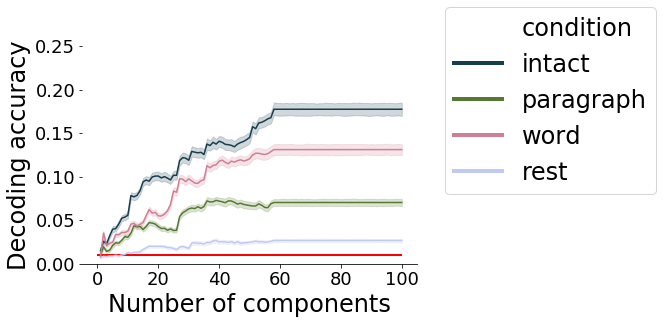

Somatomotor
2


<Figure size 432x288 with 0 Axes>

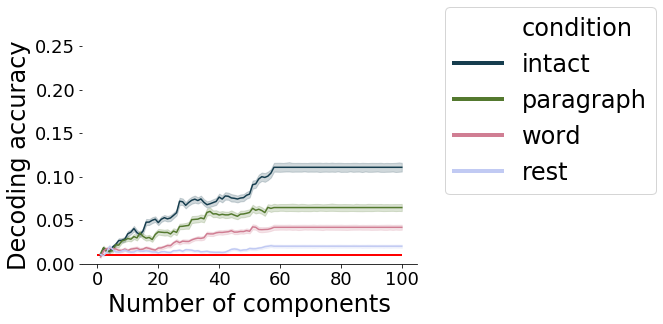

Somatomotor
3


<Figure size 432x288 with 0 Axes>

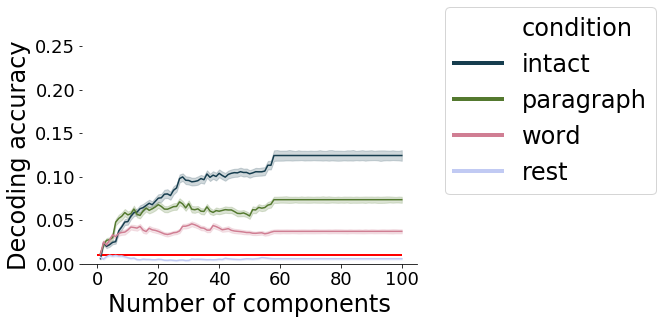

<Figure size 432x288 with 0 Axes>

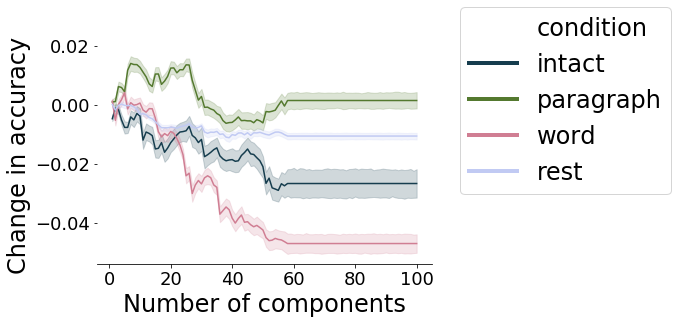

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Dorsal Attention.csv']
Dorsal Attention
1


<Figure size 432x288 with 0 Axes>

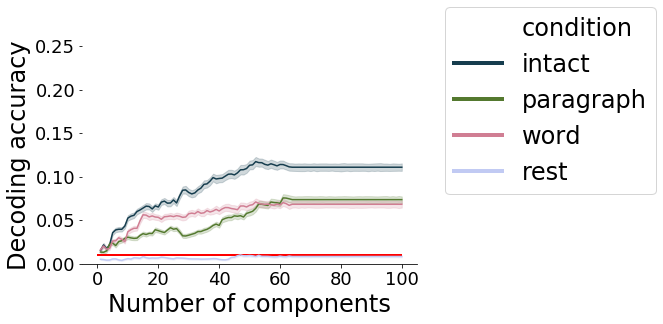

Dorsal Attention
2


<Figure size 432x288 with 0 Axes>

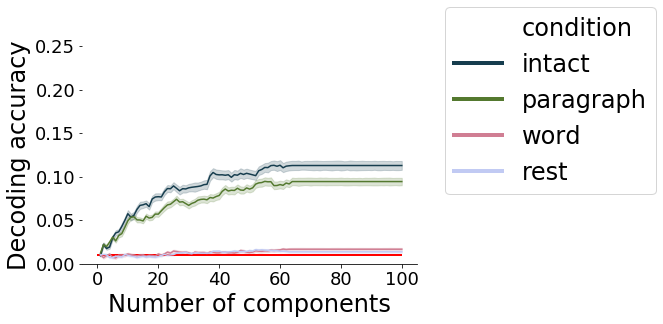

Dorsal Attention
3


<Figure size 432x288 with 0 Axes>

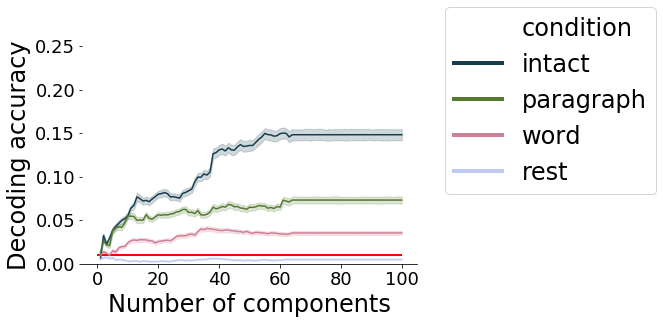

<Figure size 432x288 with 0 Axes>

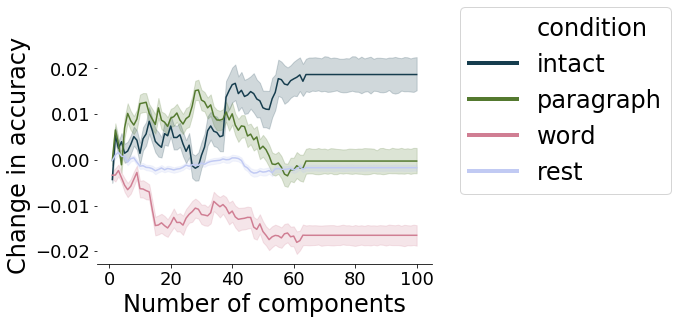

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Ventral Attention.csv']
Ventral Attention
1


<Figure size 432x288 with 0 Axes>

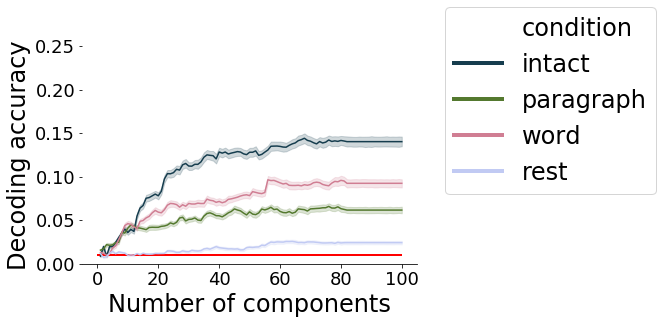

Ventral Attention
2


<Figure size 432x288 with 0 Axes>

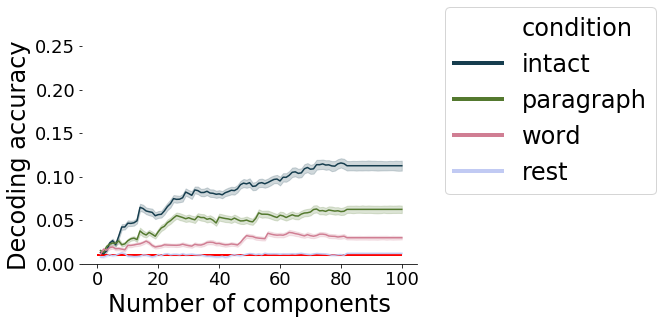

Ventral Attention
3


<Figure size 432x288 with 0 Axes>

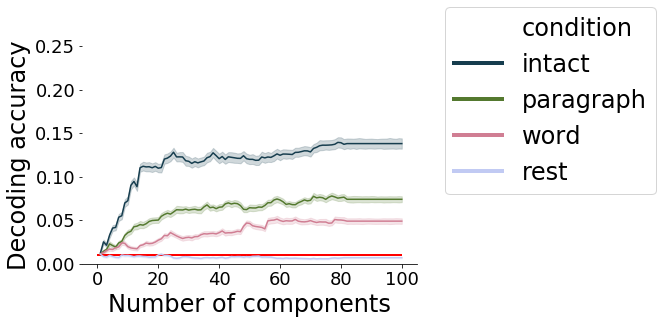

<Figure size 432x288 with 0 Axes>

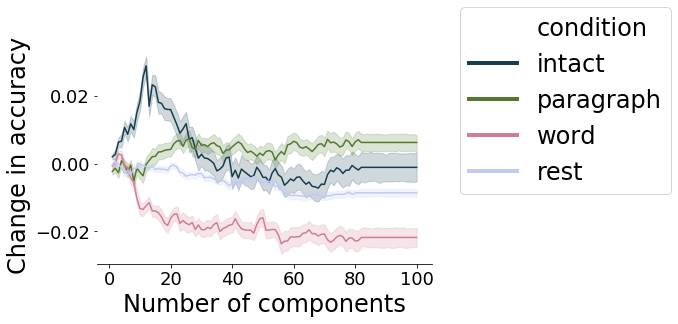

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Limbic .csv']
Limbic 
1


<Figure size 432x288 with 0 Axes>

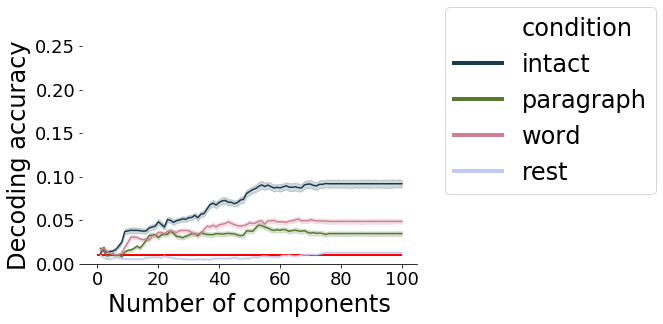

Limbic 
2


<Figure size 432x288 with 0 Axes>

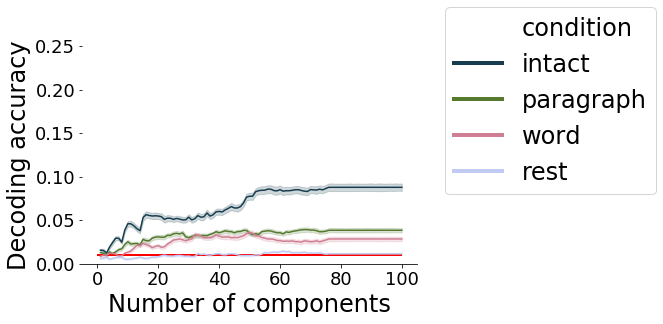

Limbic 
3


<Figure size 432x288 with 0 Axes>

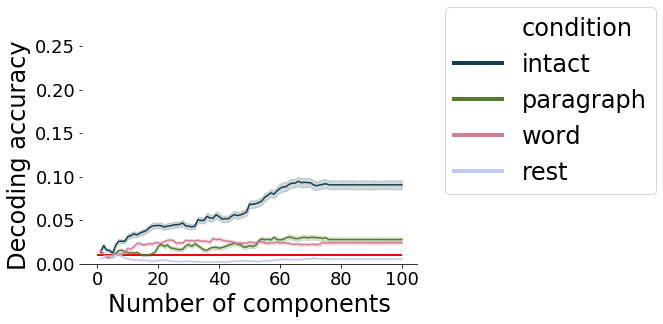

<Figure size 432x288 with 0 Axes>

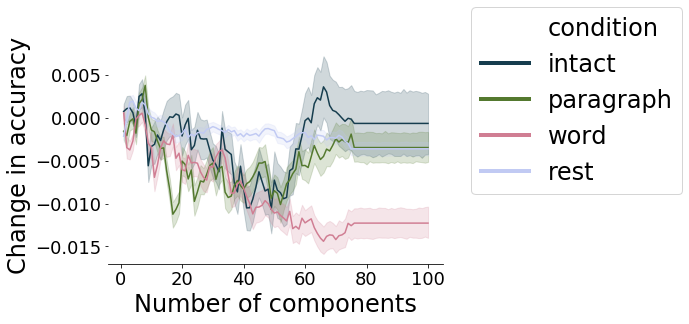

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Frontoparietal.csv']
Frontoparietal
1


<Figure size 432x288 with 0 Axes>

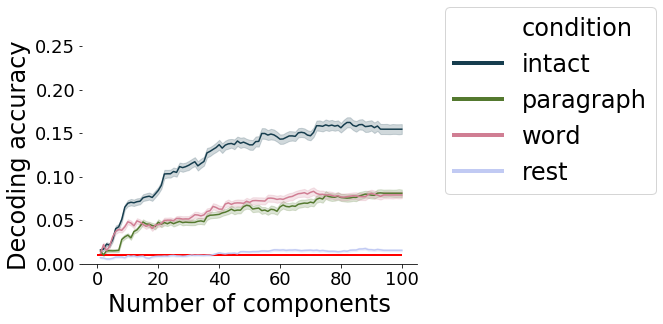

Frontoparietal
2


<Figure size 432x288 with 0 Axes>

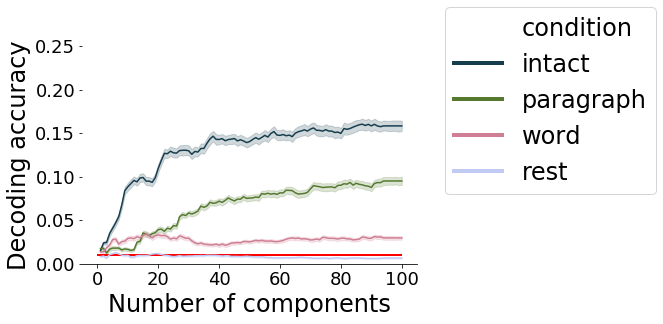

Frontoparietal
3


<Figure size 432x288 with 0 Axes>

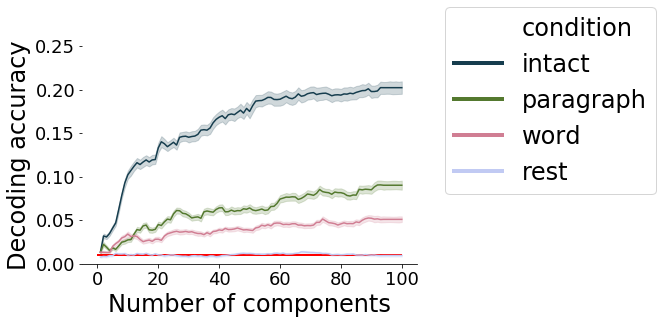

<Figure size 432x288 with 0 Axes>

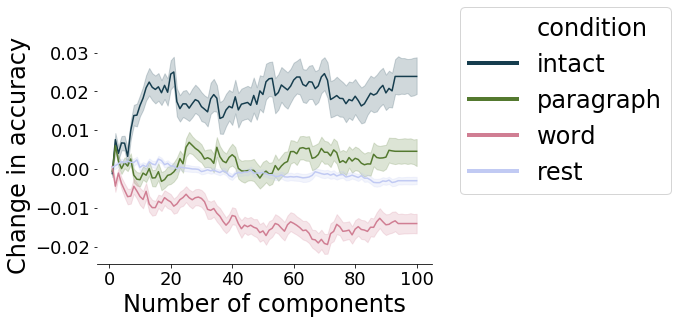

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Default.csv']
Default
1


<Figure size 432x288 with 0 Axes>

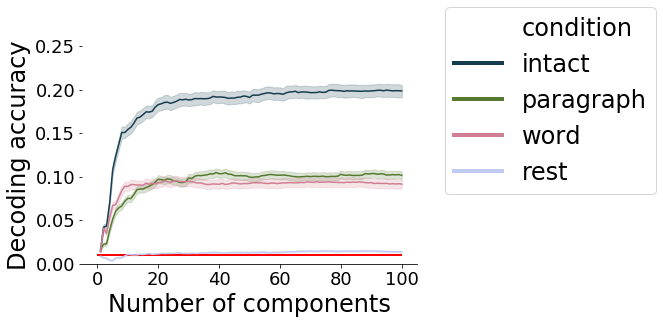

Default
2


<Figure size 432x288 with 0 Axes>

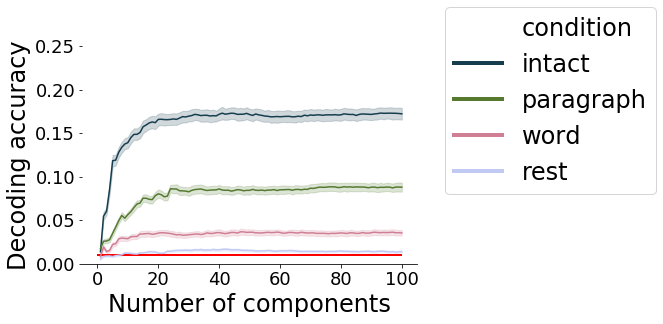

Default
3


<Figure size 432x288 with 0 Axes>

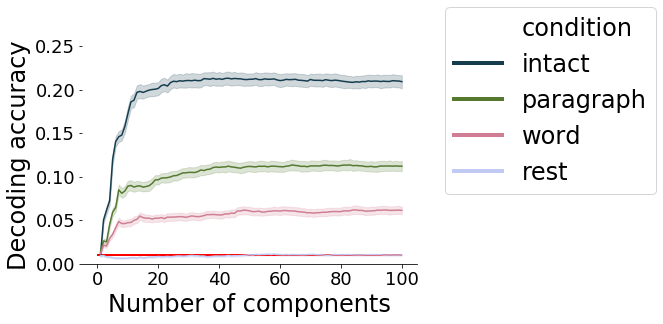

<Figure size 432x288 with 0 Axes>

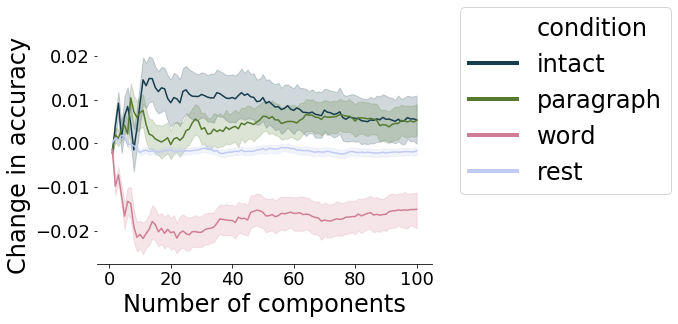

<Figure size 432x288 with 0 Axes>

In [47]:
for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    print(conds)
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
            
    for i in range(3):
        print(network_list[n])
        print(i+1)
        outfile = os.path.join(figdir, 'Accuracy_by_components_' + network_list[n] + '_third_' + str(i) + '.pdf')
        fig, ax = plt.subplots()
        sns.lineplot(x="dims", y="accuracy",
                     hue="condition",
                     data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
        sns.despine(ax=ax, left=True)
        #ax.set_title('Accuracy by components for third: ' + str(i + 1))
        ax.set_ylabel('Decoding accuracy',fontsize=24)
        ax.set_xlabel('Number of components',fontsize=24)
        ax.set_ylim(0, .25)
        ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
        l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
        for line in l.get_lines():
            line.set_linewidth(4.0)
        #fig.savefig(outfile, bbox_inches='tight')
        plt.show()
        plt.clf()
        
    data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()
    outfile = os.path.join(figdir, 'Changes_across_thirds' + str(n) + '.pdf')

    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="third",
                 hue="condition",
                 data=data_regression, palette="cubehelix", 
               hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Change in accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)

    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')
    plt.show()
    plt.clf()

In [48]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,third,condition
0,0,0.7788,0.01,0.4544,1,0,0,0,intact
1,0,0.7950,0.03,0.2493,2,0,0,0,intact
2,0,0.8110,0.02,0.3277,3,0,0,0,intact
3,0,0.8821,0.05,0.2320,4,0,0,0,intact
4,0,0.9294,0.10,0.1760,5,0,0,0,intact


In [50]:
# data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
#                            group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()

In [ ]:
# outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y="third",
#              hue="condition",
#              data=data_regression, palette="cubehelix", 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
# sns.despine(ax=ax, left=True)
# #ax.set_title('Accuracy by components for third: ' + str(i + 1))
# ax.set_ylabel('Change in accuracy',fontsize=24)
# ax.set_xlabel('Number of components',fontsize=24)

# l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
# for line in l.get_lines():
#     line.set_linewidth(4.0)
# fig.savefig(outfile, bbox_inches='tight')

In [ ]:
# for i in range(3):
#     full_data_temp = full_data[full_data['third']==i].reset_index(drop=True)
#     full_data_temp['diff'] = full_data_temp.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(5)/5
#     fig, ax = plt.subplots()
#     sns.lineplot(x="dims", y="diff",
#              hue="condition",
#              data=full_data_temp, palette="cubehelix", 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
#     sns.despine(ax=ax, left=True)
#     ax.set_title('Accuracy by components')
#     ax.set_ylabel('Decoding accuracy',fontsize=24)
#     ax.set_xlabel('Number of components',fontsize=24)
#     ax.set_ylim(0, .03)
#     ax.set_xlim(5, 100)
#     #ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#     #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
#     l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
#     for line in l.get_lines():
#         line.set_linewidth(4.0)
#     fig.savefig(outfile, bbox_inches='tight')
#     plt.show()
#     plt.clf()
# #     lm = sns.lmplot(x="dims", y="diff",
# #              hue="condition",
# #              data=full_data, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
# #            hue_order=['intact', 'paragraph', 'word', 'rest'])
# #     axes = lm.axes
# #     axes[0,0].set_ylim(0,.02)
# #     axes[0,0].set_xlim(1,100)

In [ ]:
# for i in range(3):
#     full_data_temp = full_data[full_data['third']==i].reset_index(drop=True)
#     full_data_temp['diff'] = full_data_temp.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(2)/2
# #     sns.lineplot(x="dims", y="diff",
# #              hue="condition",
# #              data=full_data_temp, palette="cubehelix", 
# #            hue_order=['intact', 'paragraph', 'word', 'rest'])
    
#     lm = sns.lmplot(x="dims", y="diff",
#              hue="condition", data=full_data_temp, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
#     axes = lm.axes
#     axes[0,0].set_ylim(0,.025)
#     axes[0,0].set_xlim(3,100)
#     plt.show()
#     plt.clf()

In [132]:
def func(x, a, b, c, d, g):

    return (((a-d)/((1+((x/c)** b))**g)) + d )


maxs_ns = np.zeros((7, 4, 4))
hills_ns = np.zeros((7, 4, 4))

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))

for n in np.arange(len(network_list)):

    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

            
    conditions = ['intact', 'paragraph', 'word', 'rest']

    hill_all = np.zeros((4, 4))
    maxs_all = np.zeros((4, 4))


    for e, c in enumerate(conditions):


        ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

        f = interp1d(xdata, func(xdata, *popt), 'cubic')
        y = f(xdata)

        hill_all[e, 0] = maxima_2(y)

        maxs_all[e, 0] = func(maxima_2(y), *popt)
        
#         plt.plot(xdata, ydata)
#         plt.plot(xdata, func(xdata, *popt), 'r-')
#         plt.axvline(x=maxima_2(y), color='g', linestyle='-')
#         plt.show()
        
#         print(maxima_2(y))
#         print(n)
#         print(c)
#         print(i)
#         plt.plot(n_derivative(y, 2))
#         plt.plot(n_derivative(y, 3))
#         plt.axvline(x=xdata[maxima_2(y)].min(), color='g', linestyle='-')
#         plt.show()
        
    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'
    
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    conditions = ['intact', 'paragraph', 'word', 'rest']

    for i in np.arange(1, 4):

        full_data_temp = full_data[full_data['third']==i-1]

        for e, c in enumerate(conditions):


            ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
            xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

            popt, pcov = curve_fit(func, xdata, ydata, maxfev=1000000)
    
            f = interp1d(xdata, func(xdata, *popt), 'cubic')
            y = f(xdata)

            hill_all[e, i] = maxima_2(y)

            maxs_all[e, i] = func(maxima_2(y), *popt)

#             plt.plot(xdata, ydata)
#             plt.plot(xdata, func(xdata, *popt), 'r-')
#             plt.axvline(x=maxima_2(y), color='g', linestyle='-')
#             plt.show()
            
#             print(maxima_2(y))
#             print(n)
#             print(c)
#             print(i)
#             plt.plot(n_derivative(y, 2))
#             plt.plot(n_derivative(y, 3))

#             plt.axvline(x=maxima_2(y), color='g', linestyle='-')
#             plt.show()
            
    hills_ns[n, :, :] = hill_all
    
    maxs_ns[n, :, :] = maxs_all

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:86: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [63]:
try_cmap = np.array([[0.368733  , 0.002724  , 0.650601, 1],
       [0.50022302, 0.01389304, 0.65714894, 1],
       [0.6201179 , 0.09824851, 0.61470924, 1],
       [0.86846771, 0.37314094, 0.39753518, 1],
       [0.93002341, 0.47633225, 0.32375425, 1],
       [0.97434661, 0.58904578, 0.24948002, 1],
       [0.99401233, 0.70882914, 0.18102124, 1]])

In [148]:
hills_try = hills_ns[np.argsort(maxs_ns[:, 0, 0])]

In [149]:
maxs_try = maxs_ns[np.argsort(maxs_ns[:, 0, 0])]

In [156]:
try_resort_cmap = try_cmap[np.argsort(maxs_ns[:, 0, 0])]

In [153]:
network_list

['Visual',
 'Somatomotor',
 'Dorsal Attention',
 'Ventral Attention',
 'Limbic ',
 'Frontoparietal',
 'Default']

In [154]:
network_resort_list = np.array(network_list)[np.argsort(maxs_ns[:, 0, 0])]

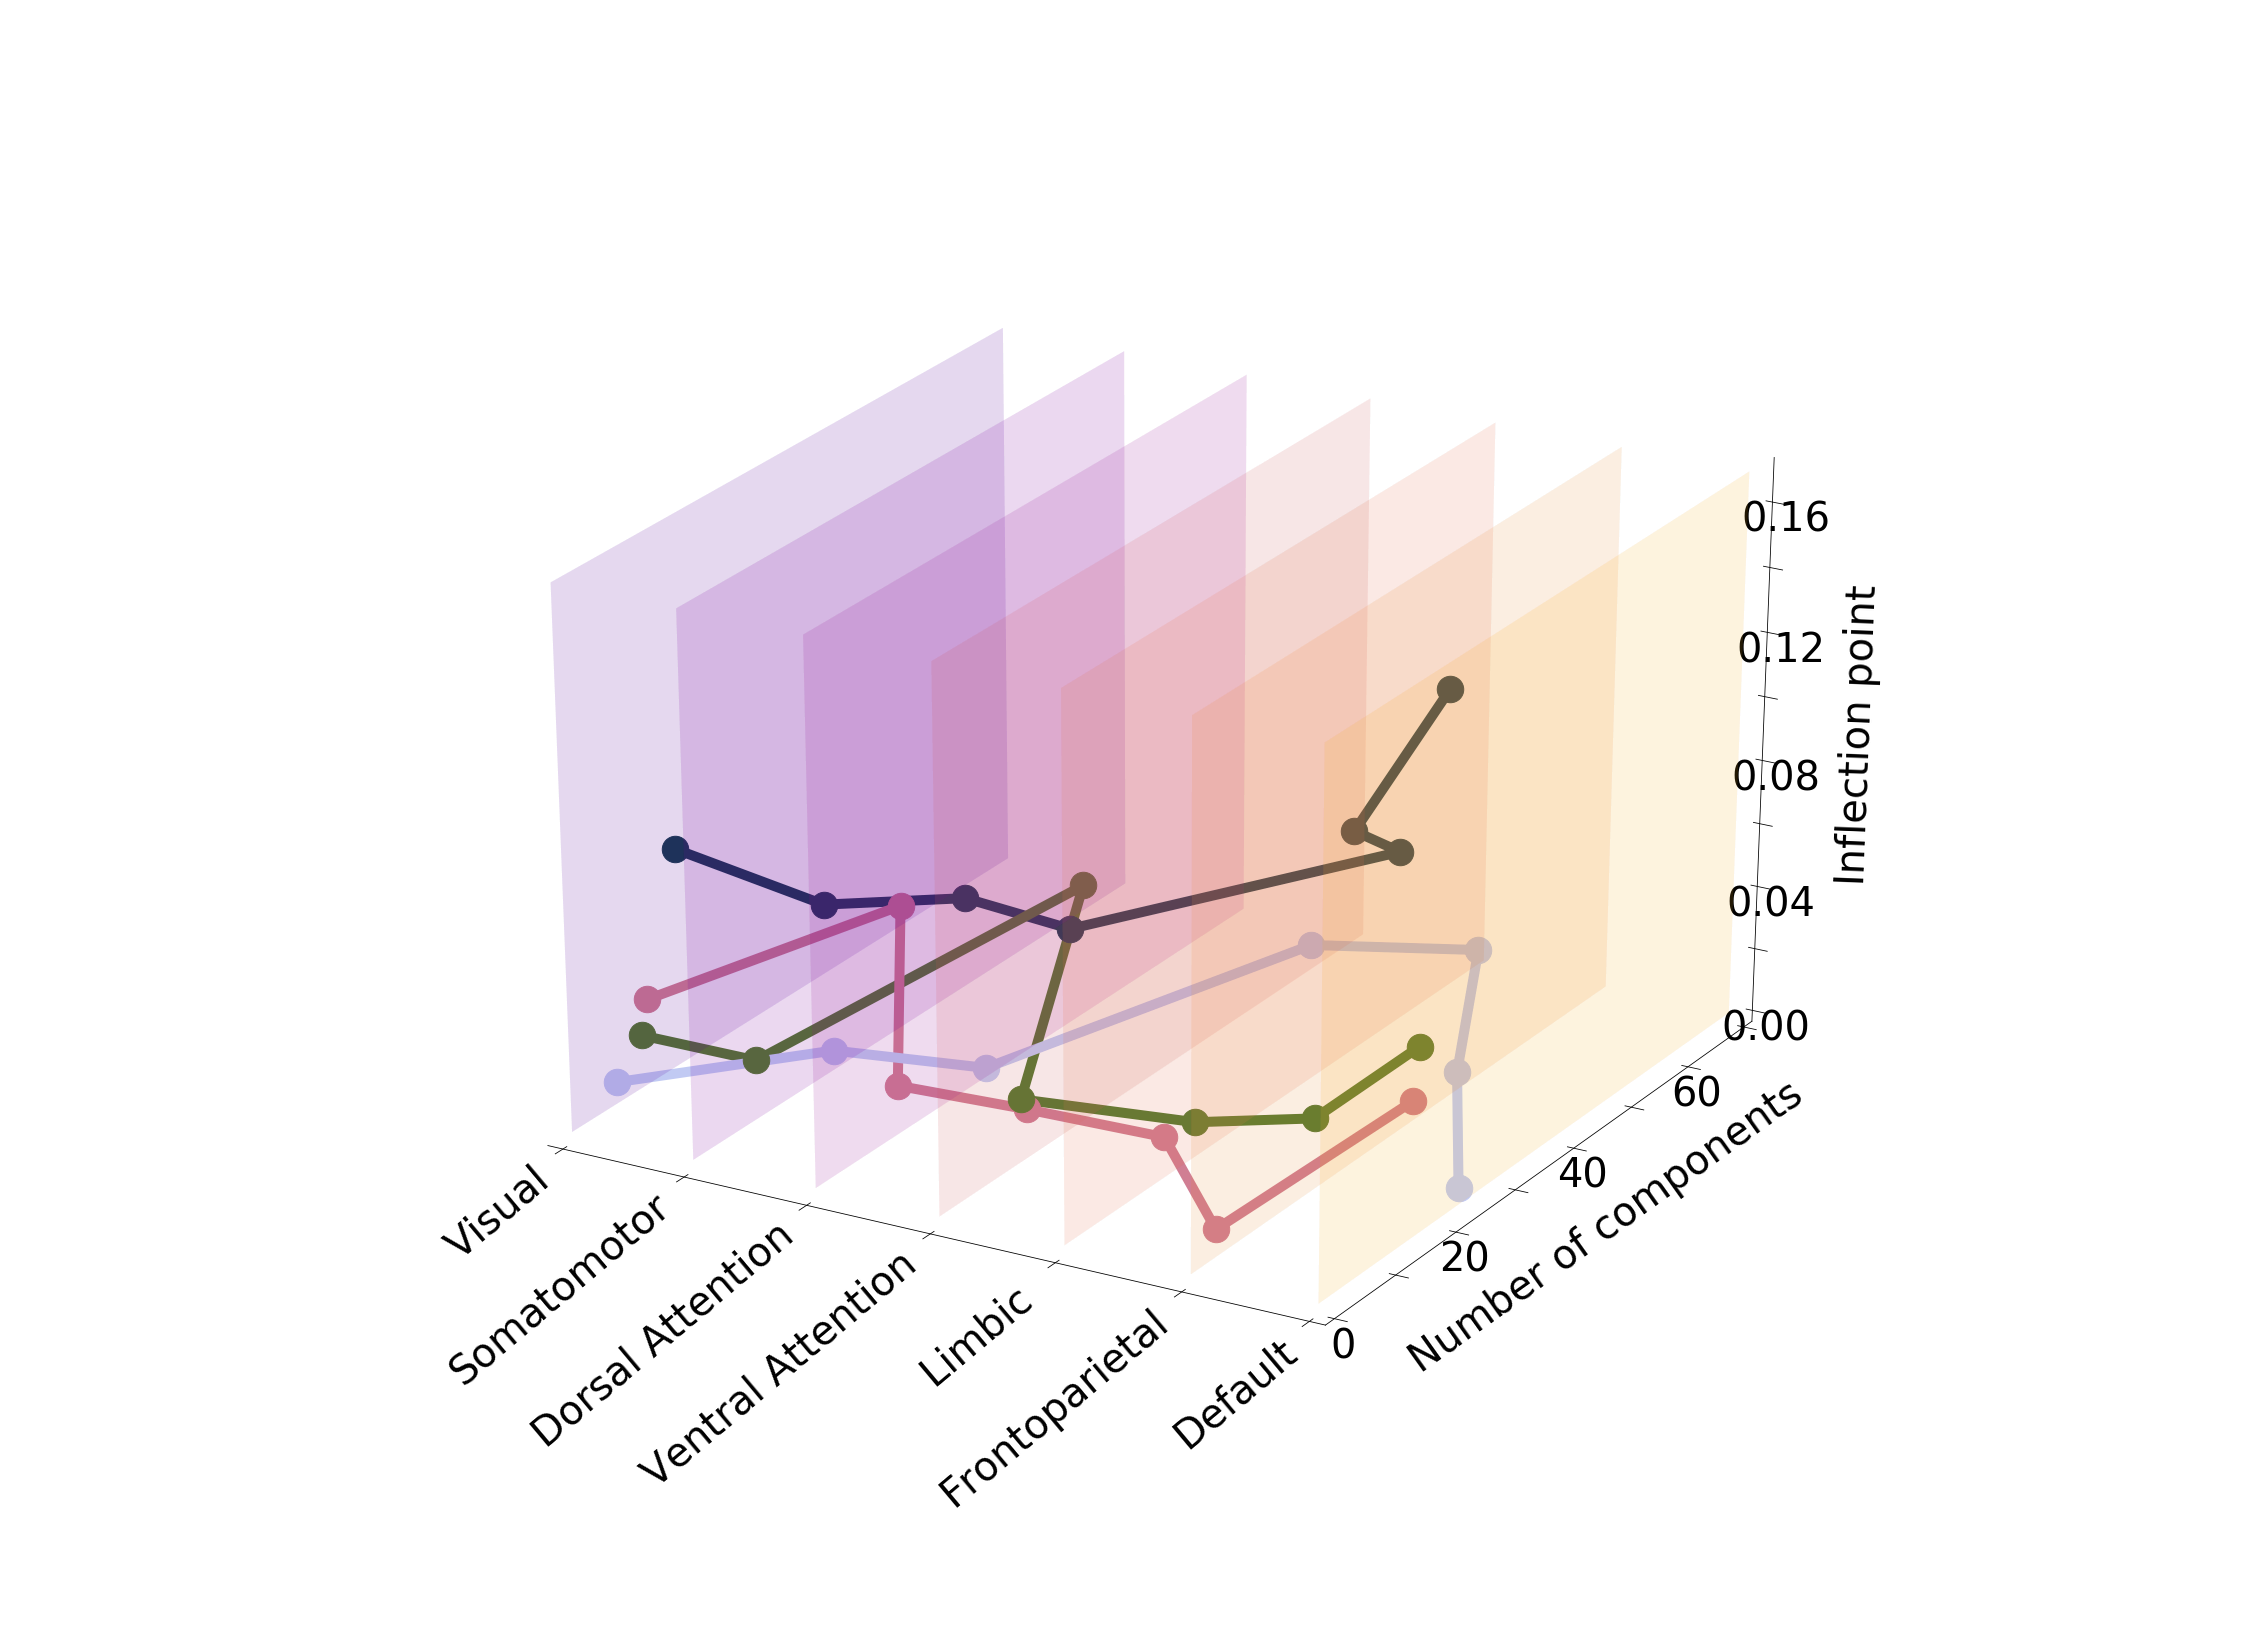

In [209]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(40,30))

ax=plt.subplot(projection='3d')

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_xlim(0,6)
ax.set_ylim(0,70)
ax.set_zlim(0,.17)

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(n, 70, 0), (n, 70, 0.17), (n, 0, 0.17), (n, 0, 0),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.04, facecolor=try_cmap[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)
        

#ax.plot([1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])

for e, c in enumerate(conditions):
    for i in np.arange(1):

    #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        if i ==0:
            ax.plot([0,1,2,3,4,5,6], hills_ns[:, e, i], maxs_ns[:, e, i], 
                    color=colors[e], linewidth=10)

        else:
            ax.plot([0,1,2,3,4,5,6], hills_try[:, e, i], maxs_try[:, e, i], 
                    color=colors[e], linewidth=2)
for n in np.arange(len(network_resort_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        
        #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        #ax.plot([0,1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])
        for i in np.arange(1):
            #ax.plot(n,hills_ns[n, e, i], maxs_ns[n, e, i],'x-')
            
            ax.scatter(n, hills_ns[n, e, i], maxs_ns[n, e, i], 
                        marker=markers[i], s=700, color=colors[e])

ax.set_xlabel(' ')
ax.set_ylabel('Number of components', labelpad=60, fontsize=40)
ax.set_zlabel('Inflection point', labelpad=60, fontsize=40)

ax.set_xticklabels(network_list, rotation=40, horizontalalignment='right', fontsize=40)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
for index, label in enumerate(ax.zaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=40)

ax.dist = 14

outfile = os.path.join(figdir, 'Acc_dims_networks.pdf')


plt.savefig(outfile, bbox_inches='tight')


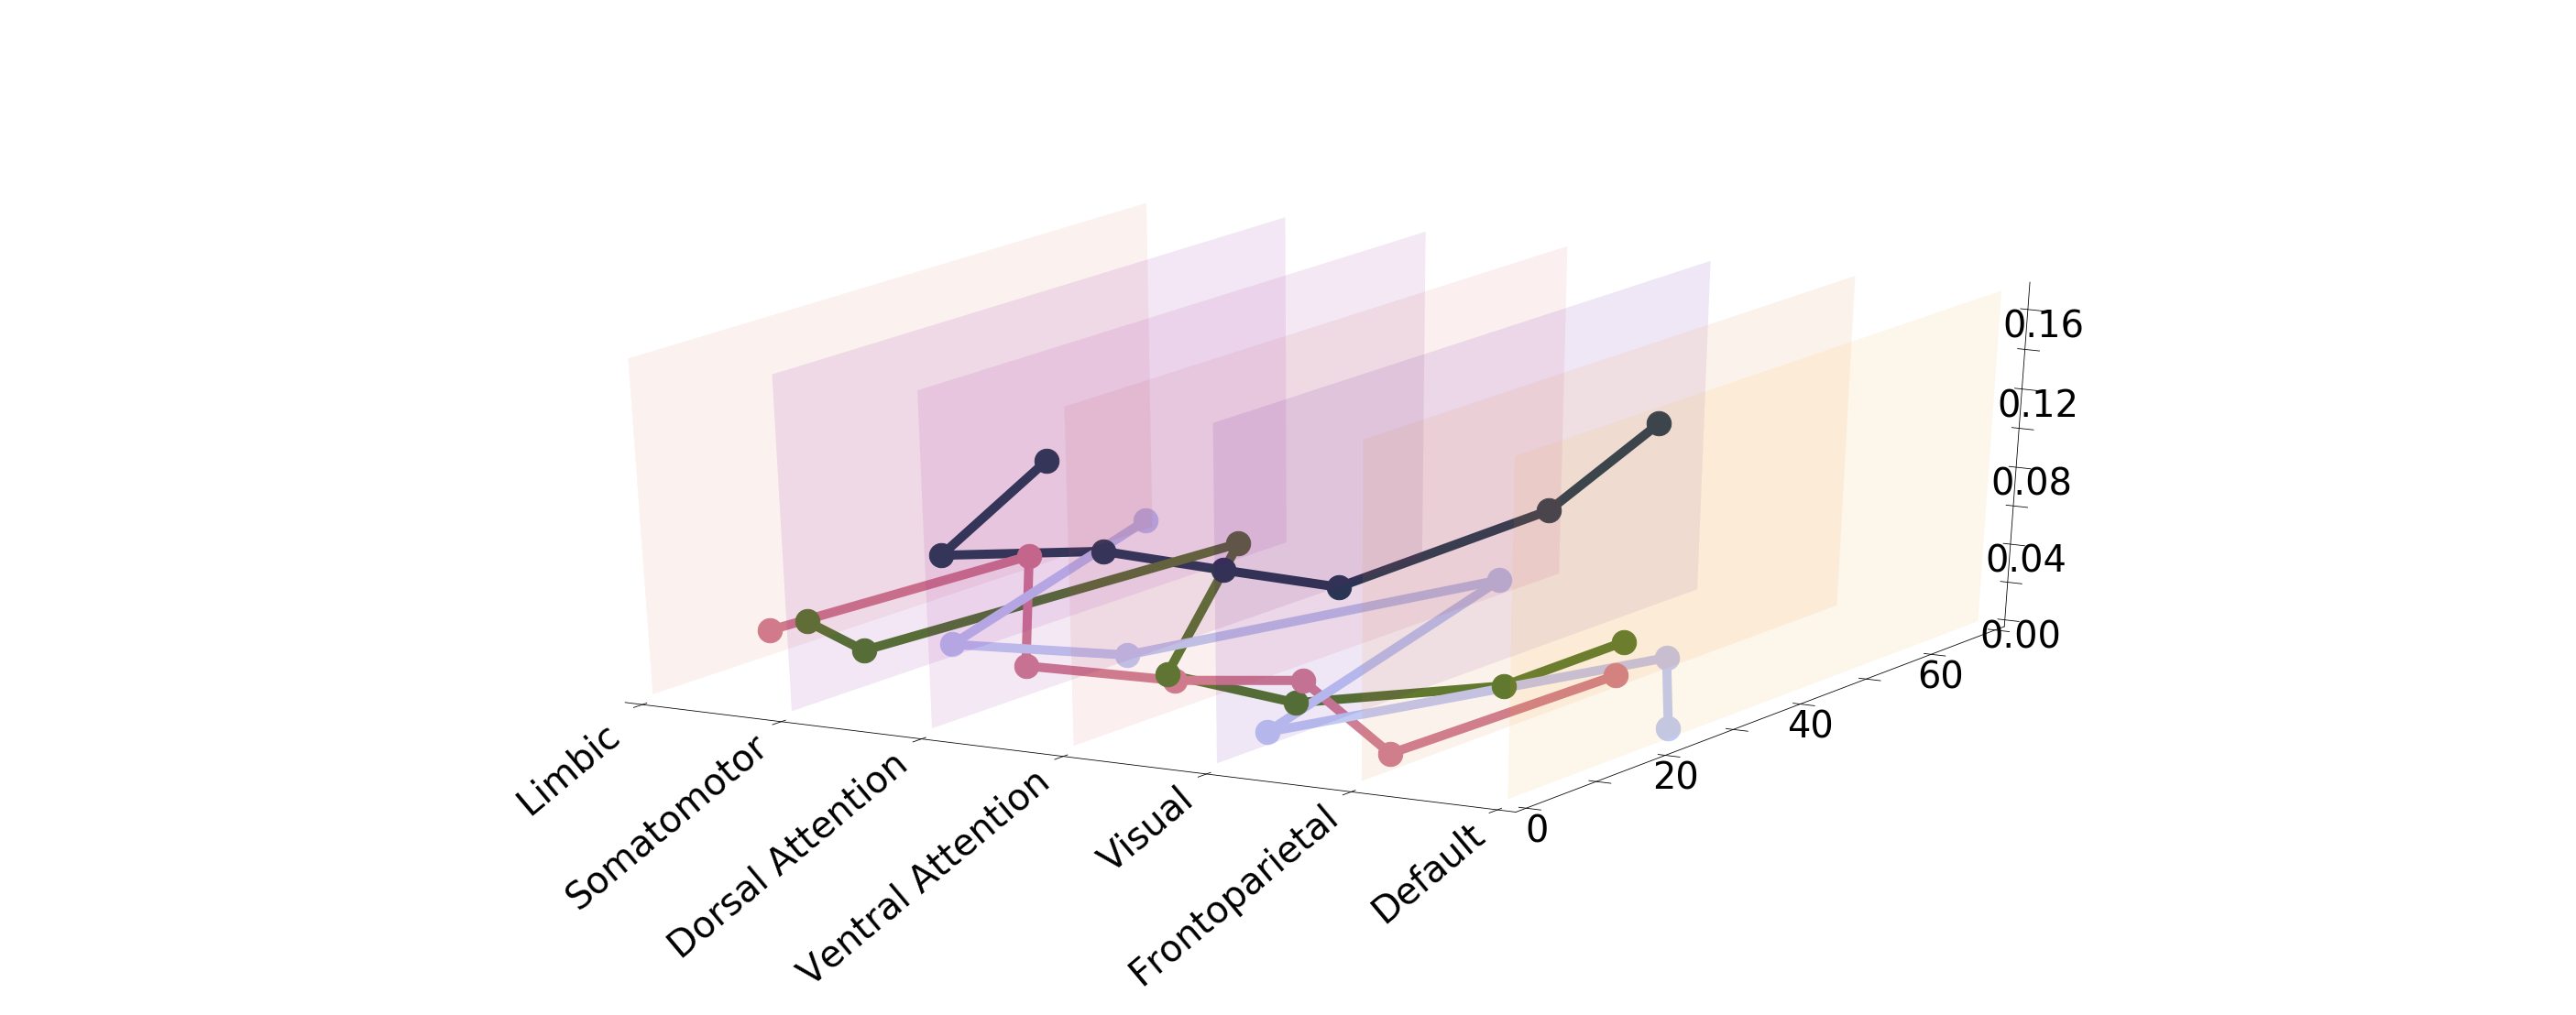

In [170]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(50,20))

ax=plt.subplot(projection='3d')

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_xlim(0,6)
ax.set_ylim(0,70)
ax.set_zlim(0,.17)

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_resort_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(n, 70, 0), (n, 70, 0.17), (n, 0, 0.17), (n, 0, 0),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.025, facecolor=try_resort_cmap[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)
        

#ax.plot([1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])

for e, c in enumerate(conditions):
    for i in np.arange(1):

    #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        if i ==0:
            ax.plot([0,1,2,3,4,5,6], hills_try[:, e, i], maxs_try[:, e, i], 
                    color=colors[e], linewidth=10)

        else:
            ax.plot([0,1,2,3,4,5,6], hills_try[:, e, i], maxs_try[:, e, i], 
                    color=colors[e], linewidth=2)
for n in np.arange(len(network_resort_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        
        #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        #ax.plot([0,1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])
        for i in np.arange(1):
            #ax.plot(n,hills_ns[n, e, i], maxs_ns[n, e, i],'x-')
            
            ax.scatter(n, hills_try[n, e, i], maxs_try[n, e, i], 
                        marker=markers[i], s=700, color=colors[e])

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_zlabel(' ')

ax.set_xticklabels(network_resort_list, rotation=40, horizontalalignment='right', fontsize=40)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
for index, label in enumerate(ax.zaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=40)

ax.dist = 14

outfile = os.path.join(figdir, 'Acc_dims_networks.pdf')


plt.savefig(outfile, bbox_inches='tight')
        
# for n in np.arange(len(network_list)):
# #for n in [6]:
#     for e, c in enumerate(conditions):
#         # 1. create vertices from points
#         #verts = [[(n, 0.42, 0), (n, .42, 0.22), (n, 0, 0.22), (n, 0, 0),]]
#         verts = [list(zip([n]*4, hills_ns[n, e], maxs_ns[n, e]))]
#         # 2. create 3d polygons and specify parameters
#         srf = Poly3DCollection(verts, alpha=.2, facecolor=color_stacked[n])
#         # 3. add polygon to the figure (current axes)
#         plt.gca().add_collection3d(srf)

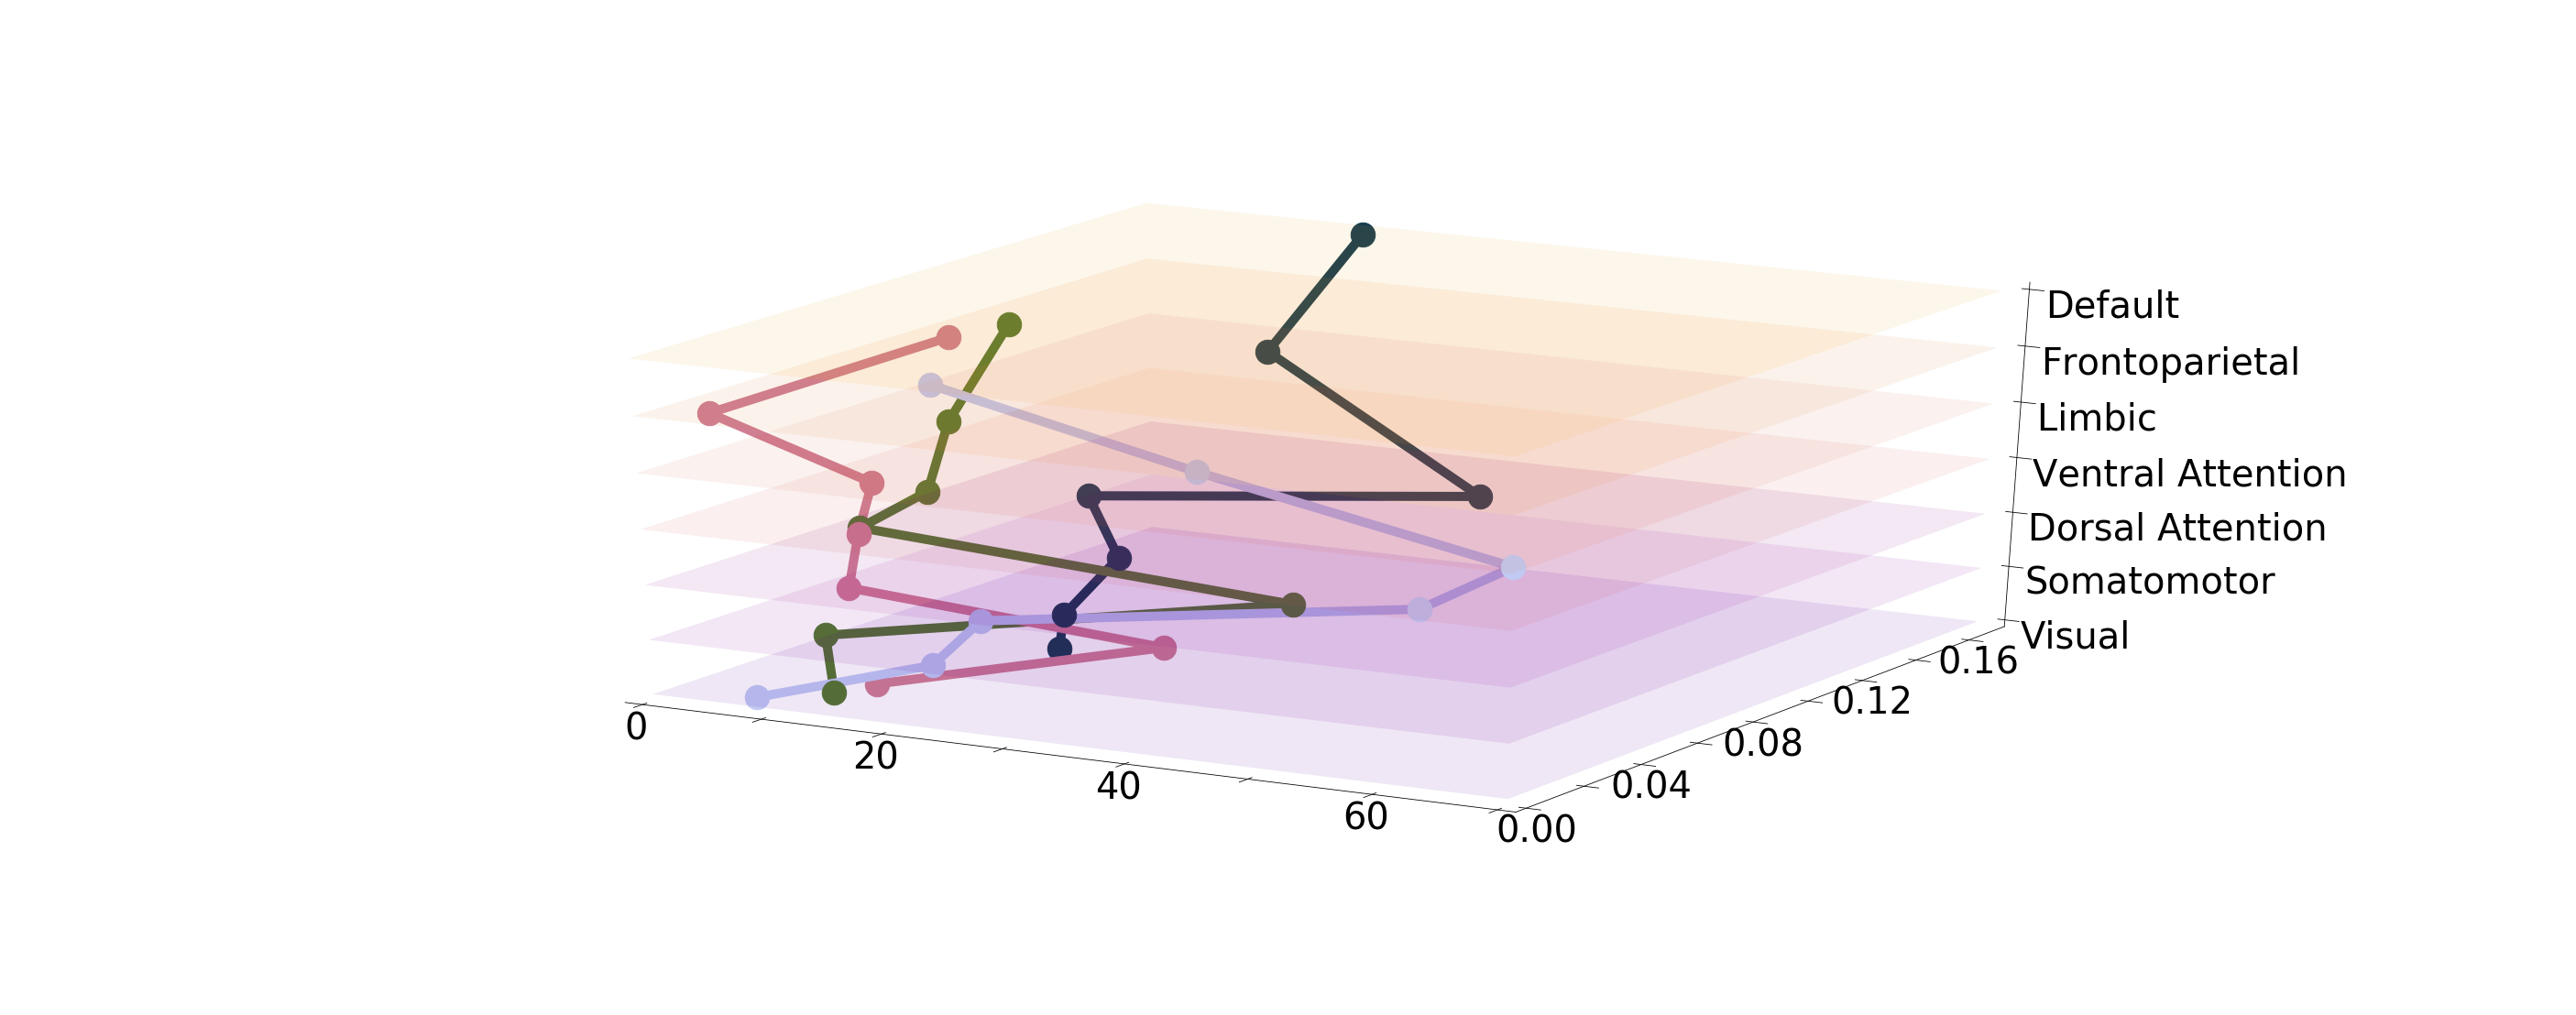

In [190]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(50,20))

ax=plt.subplot(projection='3d')

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_zlim(0,6)
ax.set_xlim(0,70)
ax.set_ylim(0,.17)

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(70, 0, n), (70, 0.17, n), (0, 0.17, n), (0, 0, n),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.025, facecolor=try_cmap[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)
        

#ax.plot([1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])

for e, c in enumerate(conditions):
    for i in np.arange(1):

    #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        if i ==0:
            ax.plot(hills_ns[:, e, i], maxs_ns[:, e, i],[0,1,2,3,4,5,6], 
                    color=colors[e], linewidth=10)

        else:
            ax.plot([0,1,2,3,4,5,6], hills_ns[:, e, i], maxs_ns[:, e, i], 
                    color=colors[e], linewidth=2)
for n in np.arange(len(network_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        
        #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        #ax.plot([0,1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])
        for i in np.arange(1):
            #ax.plot(n,hills_ns[n, e, i], maxs_ns[n, e, i],'x-')
            
            ax.scatter(hills_ns[n, e, i], maxs_ns[n, e, i], n, 
                        marker=markers[i], s=700, color=colors[e])

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_zlabel(' ')

ax.set_zticklabels(network_list, rotation=0, horizontalalignment='left', fontsize=40)

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=40)

ax.dist = 14

outfile = os.path.join(figdir, 'Acc_dims_networks.pdf')


plt.savefig(outfile, bbox_inches='tight')
        
# for n in np.arange(len(network_list)):
# #for n in [6]:
#     for e, c in enumerate(conditions):
#         # 1. create vertices from points
#         #verts = [[(n, 0.42, 0), (n, .42, 0.22), (n, 0, 0.22), (n, 0, 0),]]
#         verts = [list(zip([n]*4, hills_ns[n, e], maxs_ns[n, e]))]
#         # 2. create 3d polygons and specify parameters
#         srf = Poly3DCollection(verts, alpha=.2, facecolor=color_stacked[n])
#         # 3. add polygon to the figure (current axes)
#         plt.gca().add_collection3d(srf)

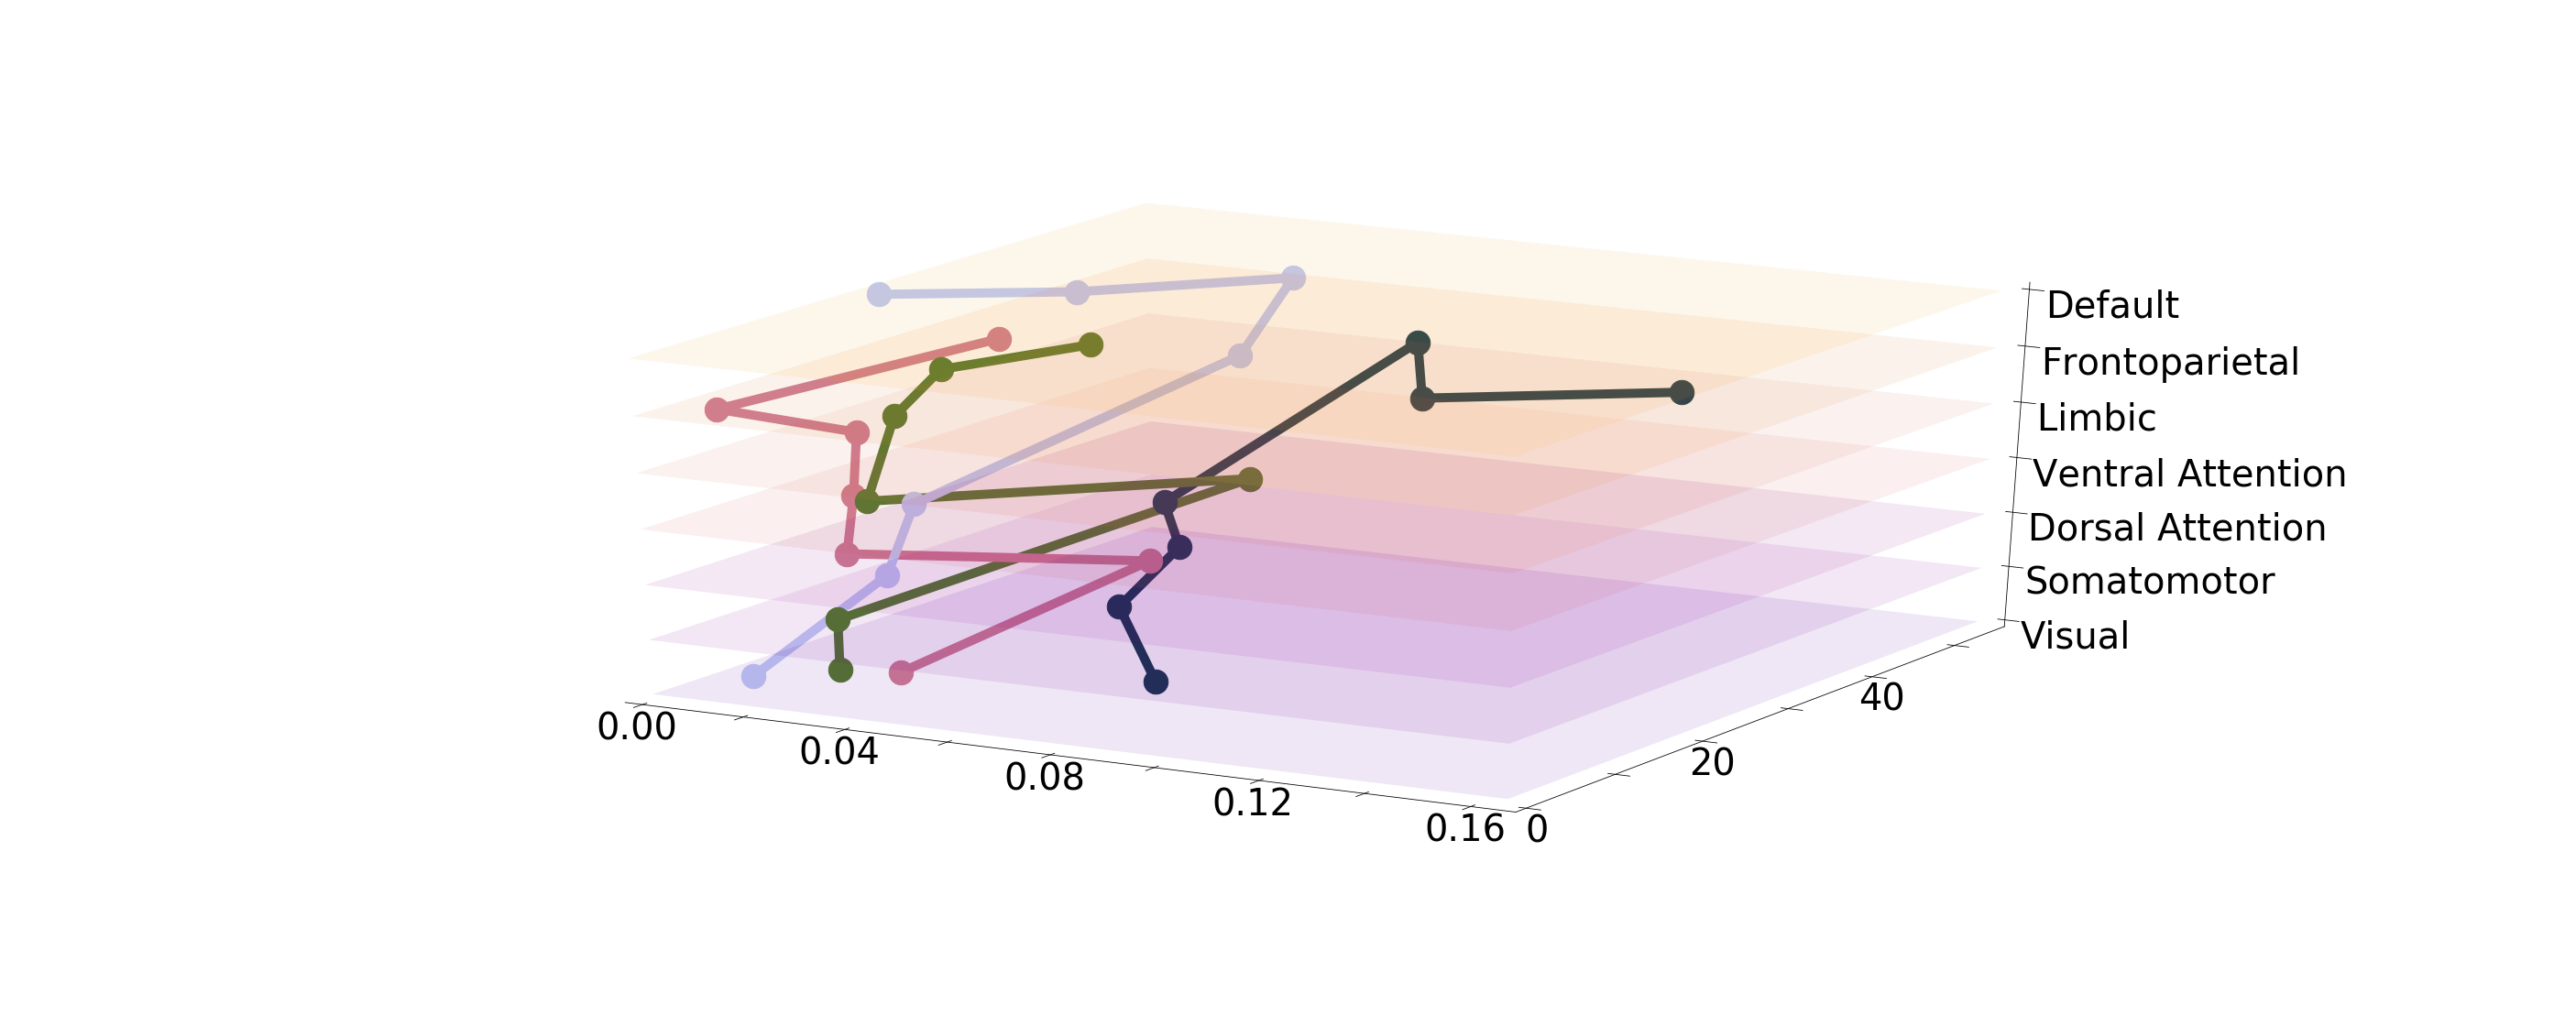

In [196]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(50,20))

ax=plt.subplot(projection='3d')

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_zlim(0,6)
ax.set_ylim(0,55)
ax.set_xlim(0,.165)

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(0, 55, n), (0.165, 55, n), (0.165,0, n), (0, 0, n),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.025, facecolor=try_cmap[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)
        

#ax.plot([1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])

for e, c in enumerate(conditions):
    for i in np.arange(1):

    #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        if i ==0:
            ax.plot(maxs_ns[:, e, i],hills_ns[:, e, i],[0,1,2,3,4,5,6], 
                    color=colors[e], linewidth=10)

        else:
            ax.plot([0,1,2,3,4,5,6], hills_try[:, e, i], maxs_try[:, e, i], 
                    color=colors[e], linewidth=2)
for n in np.arange(len(network_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        
        #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        #ax.plot([0,1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])
        for i in np.arange(1):
            #ax.plot(n,hills_ns[n, e, i], maxs_ns[n, e, i],'x-')
            
            ax.scatter(maxs_ns[n, e, i], hills_ns[n, e, i], n, 
                        marker=markers[i], s=700, color=colors[e])

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_zlabel(' ')

ax.set_zticklabels(network_list, rotation=0, horizontalalignment='left', fontsize=40)

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=40)

ax.dist = 14

outfile = os.path.join(figdir, 'Acc_dims_networks.pdf')


plt.savefig(outfile, bbox_inches='tight')
        
# for n in np.arange(len(network_list)):
# #for n in [6]:
#     for e, c in enumerate(conditions):
#         # 1. create vertices from points
#         #verts = [[(n, 0.42, 0), (n, .42, 0.22), (n, 0, 0.22), (n, 0, 0),]]
#         verts = [list(zip([n]*4, hills_ns[n, e], maxs_ns[n, e]))]
#         # 2. create 3d polygons and specify parameters
#         srf = Poly3DCollection(verts, alpha=.2, facecolor=color_stacked[n])
#         # 3. add polygon to the figure (current axes)
#         plt.gca().add_collection3d(srf)

In [106]:
figdir

'../figs'

In [60]:
outfile = os.path.join(results_dir, 'accuracy_by_network.npz')
np.savez(outfile, hills=hills_ns, maxs=maxs_ns)

In [61]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

In [175]:
maxs_ns[1, 0, 0]

0.05403799664716675

In [176]:
hills_ns[1, 0, 0]

21.0

In [177]:
maxs_ns[:, 0, 0]

array([0.06812236, 0.054038  , 0.06073268, 0.0632633 , 0.05369985,
       0.10396718, 0.16201564])

In [145]:
np.argsort(maxs_ns[:, 0, 0])

array([4, 1, 2, 3, 0, 5, 6])

In [127]:
try_sort = maxs_ns[:, 0, 0].sort()

In [128]:
try_sort

In [210]:
#00035b

In [212]:
import matplotlib
matplotlib.colors.to_rgba('#00035b')

(0.0, 0.011764705882352941, 0.3568627450980392, 1.0)

In [223]:
try_rep = np.array([0.0, 0.011764705882352941, 0.3568627450980392])

In [231]:
blue_colors = np.matlib.repmat(np.array([0.0, 0.011764705882352941, 0.3568627450980392, 0]), 7, 1)

In [230]:
blue_colors

array([[0.        , 0.01176471, 0.35686275],
       [0.        , 0.01176471, 0.35686275],
       [0.        , 0.01176471, 0.35686275],
       [0.        , 0.01176471, 0.35686275],
       [0.        , 0.01176471, 0.35686275],
       [0.        , 0.01176471, 0.35686275],
       [0.        , 0.01176471, 0.35686275]])